In [170]:
from helper import *
if conditional:
    G_test = Generator(1).type(dtype)
    G_test.load_state_dict(torch.load('../data/generator_CDL_ABCDE_ld_35_FFT.pt'))
    G_test.eval()
else:
    G_test = G_test.type(dtype)
    G_test.load_state_dict(torch.load('../data/generator_CDL_%s.pt'%channel_model))
    G_test.eval()

In [ ]:
nmse_1bitQ_CWGAN = np.zeros((128,len(SNR_vec)))
ct = 0
lambda_reg = 1e-2
lambda_d = 1e-3
for SNR in SNR_vec:
    ct += 1
    for i in range(nrepeat):
        pilot_sequence_ind = np.random.randint(0,4,size=(N_s,N_p))
        symbols = qpsk_constellation[pilot_sequence_ind]
        precoder_training = training_precoder(N_t,N_s)
        W = training_combiner(N_r,N_rx_rf)
        A = np.kron(np.matmul(symbols.T,precoder_training.T),W)
        A_real = dtype(np.real(A))
        A_imag = dtype(np.imag(A))
        for ind in range(0,H_ex.shape[2],2):
            vec_H_single = np.reshape(H_ex[:,:,ind].flatten('F'),[N_r*N_t,1])
            signal = np.matmul(H_ex[:,:,ind],np.matmul(precoder_training,symbols))
            E_s = np.multiply(signal,np.conj(signal))
            noise_matrix = (1/np.sqrt(2))*(np.random.randn(N_r,N_p)+1j*np.random.randn(N_r,N_p))
            vec_y = np.zeros((N_rx_rf*N_p,1,1),dtype='complex64')
            sign_vec_y = np.zeros((N_rx_rf*N_p,1,1),dtype='complex64')
            std_dev = (1/(10**(SNR/20)))*np.sqrt(E_s)
            rx_signal = signal + np.multiply(std_dev,noise_matrix)
            rx_signal = np.matmul(W,rx_signal)
            vec_y[:,0,0] = rx_signal.flatten('F') 
            sign_vec_y_real = dtype(np.sign(np.real(vec_y[:,:,0])))
            sign_vec_y_imag = dtype(np.sign(np.imag(vec_y[:,:,0])))
            
            def gen_output_obq(x,c):
                pred = G_test(x,c)
                pred[0,0,:,:] = dtype(std_real)*pred[0,0,:,:] + dtype(mu_real)
                pred[0,1,:,:] = dtype(std_imag)*pred[0,1,:,:] + dtype(mu_imag)
                pred_real = torch.mm(A_T_R_real,pred[0,0,:,:].view(N_t*N_r,-1)) - torch.mm(A_T_R_imag,pred[0,1,:,:].view(N_t*N_r,-1))
                pred_imag = torch.mm(A_T_R_real,pred[0,1,:,:].view(N_t*N_r,-1)) + torch.mm(A_T_R_imag,pred[0,0,:,:].view(N_t*N_r,-1))
                A_G_real = torch.mm(A_real,pred_real) - torch.mm(A_imag,pred_imag)
                A_G_imag = torch.mm(A_real,pred_imag) + torch.mm(A_imag,pred_real)
                loss1 = (torch.sum(torch.mul(sign_vec_y_real,A_G_real)) + torch.sum(torch.mul(sign_vec_y_imag,A_G_imag)))
                return -loss1 
            
            x = Variable(torch.randn(1, latent_dim)).type(dtype)
            c = torch.from_numpy(np.array([CDL[ind,0]-1])).long().type(dtype_long)
            x.requires_grad = True
            learning_rate = 1e-1
            optimizer = torch.optim.Adam([x], lr=learning_rate)
            for a in range(500): 
                optimizer.zero_grad()
                loss = gen_output_obq(x,c)
                loss.backward()
                optimizer.step()
            gen_imgs = G_test(x,c).data.cpu().numpy()
            gen_imgs[0,0,:,:] = std_real*gen_imgs[0,0,:,:] + mu_real
            gen_imgs[0,1,:,:] = std_imag*gen_imgs[0,1,:,:] + mu_imag
            gen_imgs_complex = gen_imgs[0,0,:,:] + 1j*gen_imgs[0,1,:,:]
            gen_imgs_complex = np.matmul(A_T_R,np.reshape(gen_imgs_complex,[N_t*N_r,1]))
            alph = np.sum(np.conj(gen_imgs_complex) * vec_H_single) / np.sum(np.conj(gen_imgs_complex) * gen_imgs_complex)
            nmse_1bitQ_CWGAN[int(ind/2),ct-1] = nmse_1bitQ_CWGAN[int(ind/2),ct-1] + (np.linalg.norm(alph*gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2
            print((np.linalg.norm(alph*gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2)
nmse_1bitQ_CWGAN = nmse_1bitQ_CWGAN/(nrepeat)

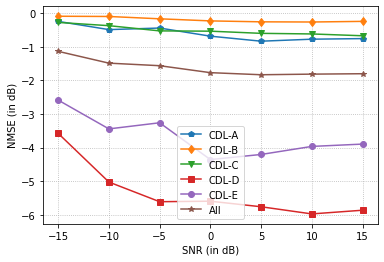

In [190]:
nmse_ABCDE = np.zeros((5,len(SNR_vec)))
nmse_ABCDE[0,:] = np.mean(nmse_1bitQ_CWGAN[0:26,:],axis=0)
nmse_ABCDE[1,:] = np.mean(nmse_1bitQ_CWGAN[26:51,:],axis=0)
nmse_ABCDE[2,:] = np.mean(nmse_1bitQ_CWGAN[51:77,:],axis=0)
nmse_ABCDE[3,:] = np.mean(nmse_1bitQ_CWGAN[77:104,:],axis=0)
nmse_ABCDE[4,:] = np.mean(nmse_1bitQ_CWGAN[104:,:],axis=0)
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[0,:]),'p-',label='CDL-A')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[1,:]),'d-',label='CDL-B')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[2,:]),'v-',label='CDL-C')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[3,:]),'s-',label='CDL-D')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[4,:]),'o-',label='CDL-E')
plt.plot(SNR_vec,10*np.log10(np.mean(nmse_1bitQ_CWGAN,axis=0)),'*-',label='All')
plt.legend()
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')

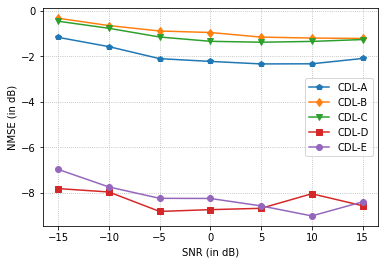

In [157]:
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_A),'p-',label='CDL-A')
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_B),'d-',label='CDL-B')
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_C),'v-',label='CDL-C')
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_D),'s-',label='CDL-D')
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_E),'o-',label='CDL-E')
plt.legend()
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')

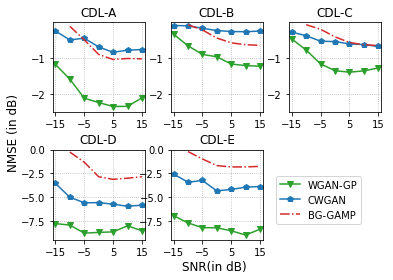

In [261]:
nmse_emgmamp = sio.loadmat('../results/nmse_1bit.mat')
SNR_vec = range(-15,20,5)
fig = plt.figure()
ax1 = plt.subplot2grid(shape=(7,54), loc=(0,0), colspan=15, rowspan=3)
ax2 = plt.subplot2grid((7,54), (0,19), colspan=15, rowspan=3)
ax3 = plt.subplot2grid((7,54), (0,38), colspan=15, rowspan=3)
ax4 = plt.subplot2grid((7,54), (4,0), colspan=15, rowspan=3)
ax5 = plt.subplot2grid((7,54), (4,19), colspan=15, rowspan=3)

ax1.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_A),'v-',label='WGAN-GP',color='#2ca02c')
ax1.plot(SNR_vec,10*np.log10(nmse_ABCDE[0,:]),'p-',label='CWGAN',color='#1f77b4')
ax1.plot(SNR_vec[1:],10*np.log10(nmse_emgmamp['nmse_arr_CDL_A']),'-.',label='BG-GAMP',color='#d62728')
ax1.grid(ls=':')
ax1.set_xlim([-16,16]); ax1.set_ylim([-2.5,0]); ax1.set_xticks((-15,-5,5,15)); ax1.set_yticks([-2,-1])

ax2.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_B),'v-',label='WGAN-GP',color='#2ca02c')
ax2.plot(SNR_vec,10*np.log10(nmse_ABCDE[1,:]),'p-',label='CWGAN',color='#1f77b4')
ax2.plot(SNR_vec[1:],10*np.log10(nmse_emgmamp['nmse_arr_CDL_B']),'-.',label='BG-GAMP',color='#d62728')
ax2.grid(ls=':')
ax2.set_xlim([-16,16]); ax2.set_ylim([-2.5,0]); ax2.set_xticks((-15,-5,5,15)); ax2.set_yticks([-2,-1])

ax3.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_C),'v-',label='WGAN-GP',color='#2ca02c')
ax3.plot(SNR_vec,10*np.log10(nmse_ABCDE[2,:]),'p-',label='CWGAN',color='#1f77b4')
ax3.plot(SNR_vec[1:],10*np.log10(nmse_emgmamp['nmse_arr_CDL_C']),'-.',label='BG-GAMP',color='#d62728')
ax3.grid(ls=':')
ax3.set_xlim([-16,16]); ax3.set_ylim([-2.5,0]); ax3.set_xticks((-15,-5,5,15)); ax3.set_yticks([-2,-1])

ax4.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_D),'v-',label='WGAN-GP',color='#2ca02c')
ax4.plot(SNR_vec,10*np.log10(nmse_ABCDE[3,:]),'p-',label='CWGAN',color='#1f77b4')
ax4.plot(SNR_vec[1:],10*np.log10(nmse_emgmamp['nmse_arr_CDL_D']),'-.',label='BG-GAMP',color='#d62728')
ax4.grid(ls=':')
ax4.set_xlim([-16,16]); ax4.set_ylim([-9.5,0]); ax4.set_xticks((-15,-5,5,15)); ax4.set_yticks([-7.5,-5,-2.5,0])

ax5.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_E),'v-',label='WGAN-GP',color='#2ca02c')
ax5.plot(SNR_vec,10*np.log10(nmse_ABCDE[4,:]),'p-',label='CWGAN',color='#1f77b4')
ax5.plot(SNR_vec[1:],10*np.log10(nmse_emgmamp['nmse_arr_CDL_E']),'-.',label='BG-GAMP',color='#d62728')
ax5.grid(ls=':')
ax5.set_xlim([-16,16]); ax5.set_ylim([-9.5,0]); ax5.set_xticks((-15,-5,5,15)); ax5.set_yticks([-7.5,-5,-2.5,0])

ax1.title.set_text('CDL-A')
ax2.title.set_text('CDL-B')
ax3.title.set_text('CDL-C')
ax4.title.set_text('CDL-D')
ax5.title.set_text('CDL-E')

fig.supylabel('NMSE (in dB)')
fig.supxlabel('SNR(in dB)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.7,0.2))
plt.savefig('../results/1bitQ_NMSE_SNR.pdf',dpi=50000)

In [ ]:
#Few bit Quantization
nmse_1bitQ_CDL_A = np.zeros((len(SNR_vec),1))
capacity_1bitQ_CDL_A = np.zeros((len(SNR_vec),1))
capacity_compute = 1
Lloyd_stepsize_vector = np.array([1.5956, 0.9957, 0.586, 0.3352, 0.1881,0.1041,0.0569, 0.0308])
stepsize_scale_factor = 1
bit = 1
def rms(y):
    return np.sqrt(np.mean(y**2))

ct = 0
lambda_reg = 1e-2
lambda_d = 1e-3
for SNR in SNR_vec:
    ct += 1
    for i in range(nrepeat):
        pilot_sequence_ind = np.random.randint(0,4,size=(N_s,N_p))
        symbols = qpsk_constellation[pilot_sequence_ind]
        precoder_training = training_precoder(N_t,N_s)
        W = training_combiner(N_r,N_rx_rf)
        A = np.kron(np.matmul(symbols.T,precoder_training.T),W)
        A_real = dtype(np.real(A))
        A_imag = dtype(np.imag(A))
        for ind in range(ntest):
            vec_H_single = np.reshape(H_ex[:,:,ind].flatten('F'),[N_r*N_t,1])
            signal = np.matmul(H_ex[:,:,ind],np.matmul(precoder_training,symbols))
            E_s = np.multiply(signal,np.conj(signal))
            noise_matrix = (1/np.sqrt(2))*(np.random.randn(N_r,N_p)+1j*np.random.randn(N_r,N_p))
            vec_y = np.zeros((N_rx_rf*N_p,1,1),dtype='complex64')
            sign_vec_y = np.zeros((N_rx_rf*N_p,1,1),dtype='complex64')
            std_dev = (1/(10**(SNR/20)))*np.sqrt(E_s)
            rx_signal = signal + np.multiply(std_dev,noise_matrix)
            rx_signal = np.matmul(W,rx_signal)
            vec_y[:,0,0] = rx_signal.flatten('F') 
            
            #Few bit Quantization
            stepsize = stepsize_scale_factor * rms(np.array([np.real(vec_y[:,:,0]), np.imag(vec_y[:,:,0])]))* Lloyd_stepsize_vector[bit-1];
            
            sign_vec_y_real = dtype(np.multiply(np.sign(np.real(vec_y[:,:,0])),(np.minimum(np.ceil(np.abs(np.real(vec_y[:,:,0]))/stepsize) , 2**(bit-1)) - 1/2)) * stepsize)
            sign_vec_y_imag = dtype(np.multiply(np.sign(np.imag(vec_y[:,:,0])),(np.minimum(np.ceil(np.abs(np.imag(vec_y[:,:,0]))/stepsize) , 2**(bit-1)) - 1/2)) * stepsize)
            
            def gen_output_obq(x):
                pred = G_test(x)
                pred[0,0,:,:] = dtype(std_real)*pred[0,0,:,:] + dtype(mu_real)
                pred[0,1,:,:] = dtype(std_imag)*pred[0,1,:,:] + dtype(mu_imag)
                pred_real = torch.mm(A_T_R_real,pred[0,0,:,:].view(N_t*N_r,-1)) - torch.mm(A_T_R_imag,pred[0,1,:,:].view(N_t*N_r,-1))
                pred_imag = torch.mm(A_T_R_real,pred[0,1,:,:].view(N_t*N_r,-1)) + torch.mm(A_T_R_imag,pred[0,0,:,:].view(N_t*N_r,-1))
                A_G_real = torch.mm(A_real,pred_real) - torch.mm(A_imag,pred_imag)
                A_G_imag = torch.mm(A_real,pred_imag) + torch.mm(A_imag,pred_real)
                loss1 = (torch.sum(torch.mul(sign_vec_y_real,A_G_real)) + torch.sum(torch.mul(sign_vec_y_imag,A_G_imag)))
                return -loss1 
            
            x = Variable(torch.randn(1, latent_dim)).type(dtype)
            x.requires_grad = True
            learning_rate = 1e-1
            optimizer = torch.optim.Adam([x], lr=learning_rate)
            for a in range(500): 
                optimizer.zero_grad()
                loss = gen_output_obq(x)
                loss.backward()
                optimizer.step()
            gen_imgs = G_test(x).data.cpu().numpy()
            gen_imgs[0,0,:,:] = std_real*gen_imgs[0,0,:,:] + mu_real
            gen_imgs[0,1,:,:] = std_imag*gen_imgs[0,1,:,:] + mu_imag
            gen_imgs_complex = gen_imgs[0,0,:,:] + 1j*gen_imgs[0,1,:,:]
            gen_imgs_complex = np.matmul(A_T_R,np.reshape(gen_imgs_complex,[N_t*N_r,1]))
            alph = np.sum(np.conj(gen_imgs_complex) * vec_H_single) / np.sum(np.conj(gen_imgs_complex) * gen_imgs_complex)
            nmse_1bitQ_CDL_A[ct-1,0] = nmse_1bitQ_CDL_A[ct-1,0] + (np.linalg.norm(alph*gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2
            print((np.linalg.norm(alph*gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2)

            #Capacity Computation
            if capacity_compute == 1:
                H = np.reshape(alph*gen_imgs_complex,[N_r,N_t],order='F')
                U,S,VH = np.linalg.svd(H,full_matrices=False)
                H_true = np.reshape(H_ex[:,:,ind],[N_r,N_t]);
                gain = np.abs(np.matmul(np.matmul(np.matrix(U[:,0:1]).getH(),H_true),np.matrix(VH).getH()[:,0:1])[0,0])
                C = np.log2(1 + (10**(SNR/10))*gain*gain);
                capacity_1bitQ_CDL_A[ct-1,0] += C
                print(C)

nmse_1bitQ_CDL_A = nmse_1bitQ_CDL_A/(ntest*nrepeat)

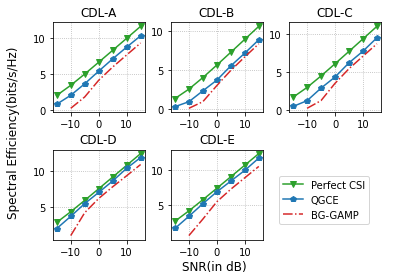

In [259]:
capacity_GAMP = sio.loadmat('../results/capacity_GAMP.mat')
capacity_max = sio.loadmat('../results/capacity_max.mat')
SNR_vec = range(-15,20,5)
fig = plt.figure()
ax1 = plt.subplot2grid(shape=(7,54), loc=(0,0), colspan=15, rowspan=3)
ax2 = plt.subplot2grid((7,54), (0,19), colspan=15, rowspan=3)
ax3 = plt.subplot2grid((7,54), (0,38), colspan=15, rowspan=3)
ax4 = plt.subplot2grid((7,54), (4,0), colspan=15, rowspan=3)
ax5 = plt.subplot2grid((7,54), (4,19), colspan=15, rowspan=3)

ax1.plot(SNR_vec,capacity_max['capacity_CDL_A']/(ntest),'v-',label='Perfect CSI',color='#2ca02c')
ax1.plot(SNR_vec,capacity_1bitQ_CDL_A/(ntest*nrepeat),'p-',label='QGCE',color='#1f77b4')
ax1.plot(SNR_vec[1:],capacity_GAMP['capacity_1bitQ_CDL_A']/(ntest*nrepeat*2),'-.',label='BG-GAMP',color='#d62728')
ax1.grid(ls=':')

ax2.plot(SNR_vec,capacity_max['capacity_CDL_B']/(ntest),'v-',label='Perfect CSI',color='#2ca02c')
ax2.plot(SNR_vec,capacity_1bitQ_CDL_B/(ntest*nrepeat),'p-',label='QGCE',color='#1f77b4')
ax2.plot(SNR_vec[1:],capacity_GAMP['capacity_1bitQ_CDL_B']/(ntest*nrepeat*2),'-.',label='BG-GAMP',color='#d62728')
ax2.grid(ls=':')

ax3.plot(SNR_vec,capacity_max['capacity_CDL_C']/(ntest),'v-',label='Perfect CSI',color='#2ca02c')
ax3.plot(SNR_vec,capacity_1bitQ_CDL_C/(ntest*nrepeat),'p-',label='QGCE',color='#1f77b4')
ax3.plot(SNR_vec[1:],capacity_GAMP['capacity_1bitQ_CDL_C']/(ntest*nrepeat*2),'-.',label='BG-GAMP',color='#d62728')
ax3.grid(ls=':')

ax4.plot(SNR_vec,capacity_max['capacity_CDL_D']/(ntest),'v-',label='Perfect CSI',color='#2ca02c')
ax4.plot(SNR_vec,capacity_1bitQ_CDL_D/(ntest*nrepeat),'p-',label='QGCE',color='#1f77b4')
ax4.plot(SNR_vec[1:],capacity_GAMP['capacity_1bitQ_CDL_D']/(ntest*nrepeat*2),'-.',label='BG-GAMP',color='#d62728')
ax4.grid(ls=':')

ax5.plot(SNR_vec,capacity_max['capacity_CDL_E']/(ntest),'v-',label='Perfect CSI',color='#2ca02c')
ax5.plot(SNR_vec,capacity_1bitQ_CDL_E/(ntest*nrepeat),'p-',label='QGCE',color='#1f77b4')
ax5.plot(SNR_vec[1:],capacity_GAMP['capacity_1bitQ_CDL_E']/(ntest*nrepeat*2),'-.',label='BG-GAMP',color='#d62728')
ax5.grid(ls=':')

ax1.title.set_text('CDL-A')
ax2.title.set_text('CDL-B')
ax3.title.set_text('CDL-C')
ax4.title.set_text('CDL-D')
ax5.title.set_text('CDL-E')

fig.supylabel('Spectral Efficiency(bits/s/Hz)')
fig.supxlabel('SNR(in dB)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.7,0.2))
plt.savefig('results/1bitQ_capacity_SNR.pdf',dpi=50000)

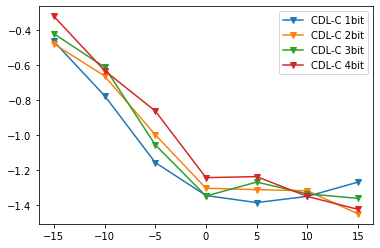

In [92]:
plt.plot(SNR_vec,10*np.log10(nmse_1bitQ_CDL_C),'v-',label='CDL-C 1bit')
plt.plot(SNR_vec,10*np.log10(nmse_2bitQ_CDL_C),'v-',label='CDL-C 2bit')
plt.plot(SNR_vec,10*np.log10(nmse_3bitQ_CDL_C),'v-',label='CDL-C 3bit')
plt.plot(SNR_vec,10*np.log10(nmse_4bitQ_CDL_C),'v-',label='CDL-C 4bit')
plt.legend()